In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='/MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/MNIST', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=4)

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]


In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
        )
        # 이미지 데이터 처리를 위해 cnn을 사용
        self.flatten = nn.Flatten(start_dim=1)
        # 완전 연결층
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, encoded_space_dim),
        )

    def forward(self, x):
        #print(x.shape)
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [11]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(), # 마지막 층은 sigmoid 함수 사용
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_cnn(x)
        return x

In [12]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=3 * 3 * 32).to(device)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=3 * 3 * 32).to(device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = optim.Adam(params_to_optimize, lr=1e-3, weight_decay=1e-5)
loss = nn.MSELoss()

In [13]:
def train(encoder, decoder, train_loader, optimizer, loss_fn, device, noise_factor=0.3):
    encoder.train()
    decoder.train()

    train_loss = []
    for image_batch, _ in train_loader:
        image_batch = image_batch.to(device)

        # 노이즈 추가
        noisy_image_batch = image_batch + noise_factor * torch.randn(*image_batch.shape).to(device)
        noisy_image_batch = torch.clamp(noisy_image_batch, 0., 1.)

        # 인코더와 디코더에 통과
        encoded_data = encoder(noisy_image_batch)
        decoded_data = decoder(encoded_data)

        # 손실 계산
        batch_loss = loss_fn(decoded_data, noisy_image_batch)

        # 역전파 및 최적화
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        train_loss.append(batch_loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [14]:
def test(encoder, decoder, test_loader, device, noise_factor=0.3):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in test_loader:
            image_batch = image_batch.to(device)

            # 인코더와 디코더에 통과
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())

            # 손실 계산
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss(conc_out, conc_label)

    return val_loss.data

In [15]:
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # 노이즈 추가
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        image_noisy = img + noise_factor * torch.randn(*img.shape).to(device)
        image_noisy = torch.clamp(image_noisy, 0., 1.)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy.to(device))).cpu()

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("Image")
        ax = plt.subplot(3,n,i+n+1)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n//2:
            ax.set_title("Noisy Image")
        ax = plt.subplot(3,n,i+2*n+1)
        plt.imshow(rec_img.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title("Reconstructed Image")

    #plt.subplot(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

    plt.show()

Epoch [1/30], Train Loss: 0.0796, Validation Loss: 0.0488


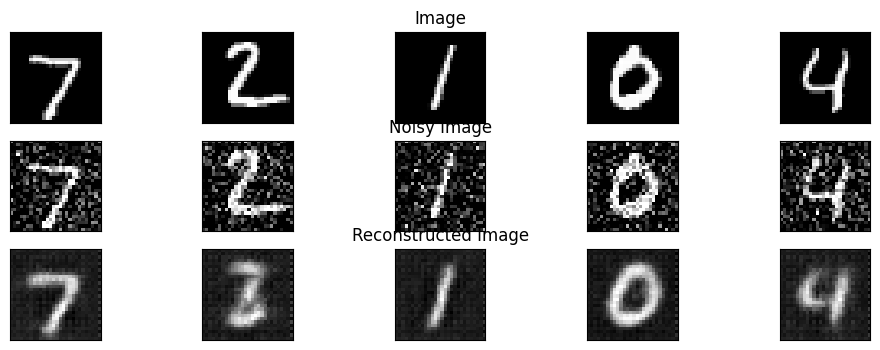

Epoch [2/30], Train Loss: 0.0546, Validation Loss: 0.0443


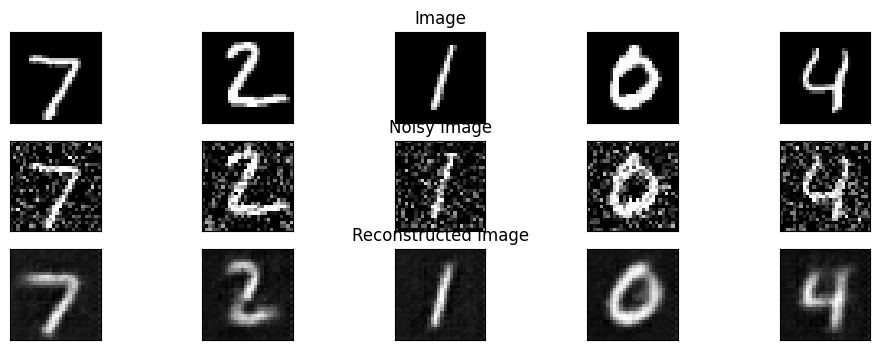

Epoch [3/30], Train Loss: 0.0531, Validation Loss: 0.0428


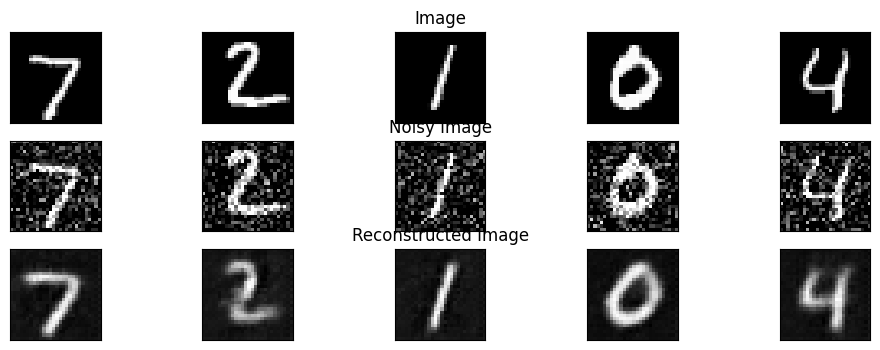

Epoch [4/30], Train Loss: 0.0524, Validation Loss: 0.0423


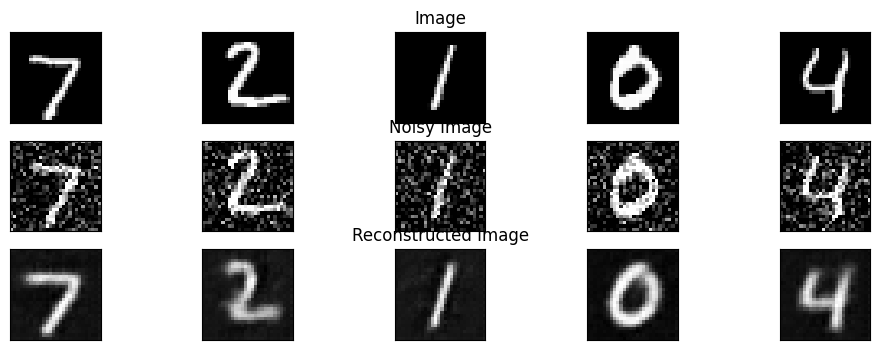

Epoch [5/30], Train Loss: 0.0519, Validation Loss: 0.0418


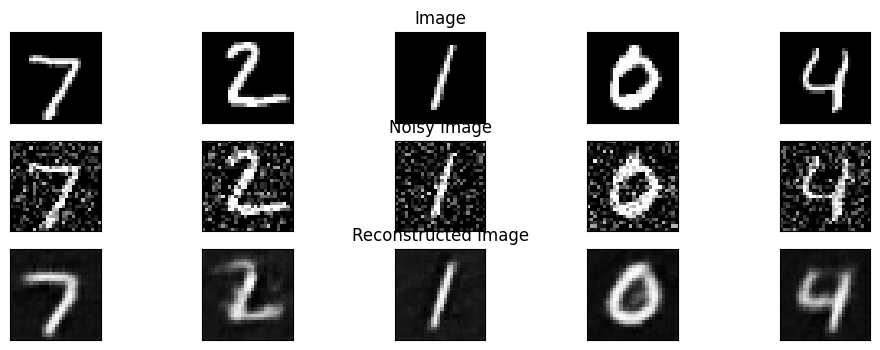

Epoch [6/30], Train Loss: 0.0515, Validation Loss: 0.0408


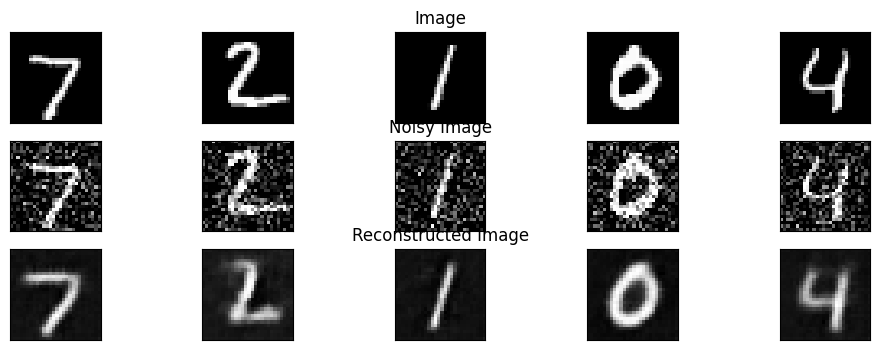

Epoch [7/30], Train Loss: 0.0512, Validation Loss: 0.0404


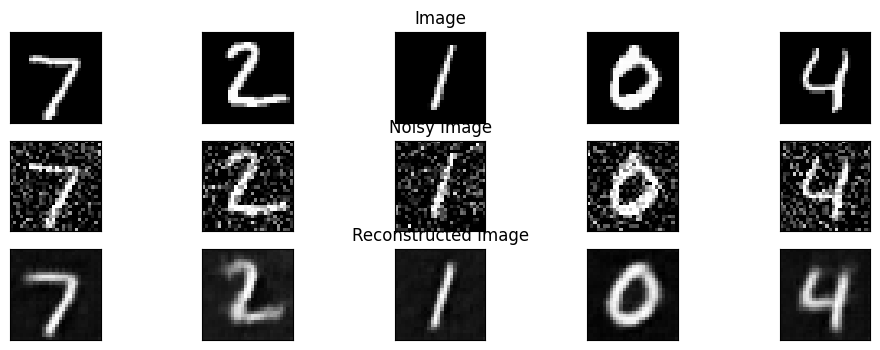

Epoch [8/30], Train Loss: 0.0511, Validation Loss: 0.0404


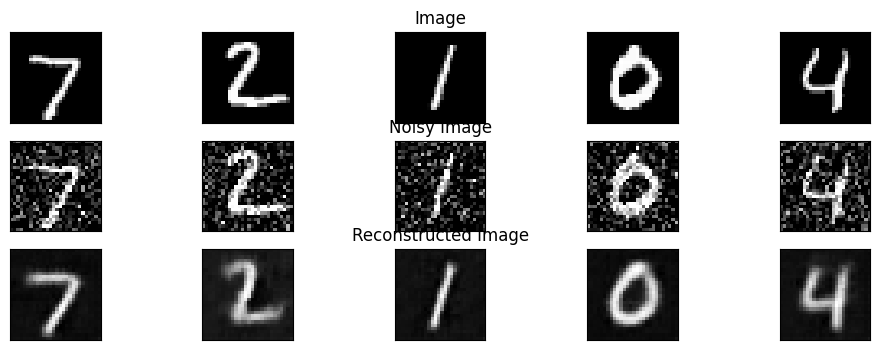

Epoch [9/30], Train Loss: 0.0509, Validation Loss: 0.0405


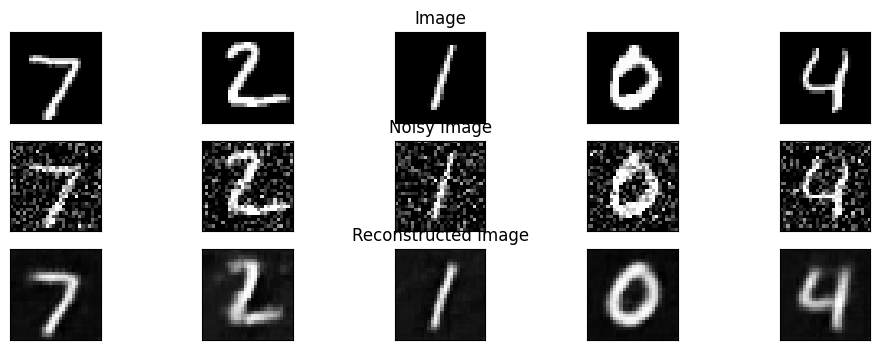

Epoch [10/30], Train Loss: 0.0507, Validation Loss: 0.0396


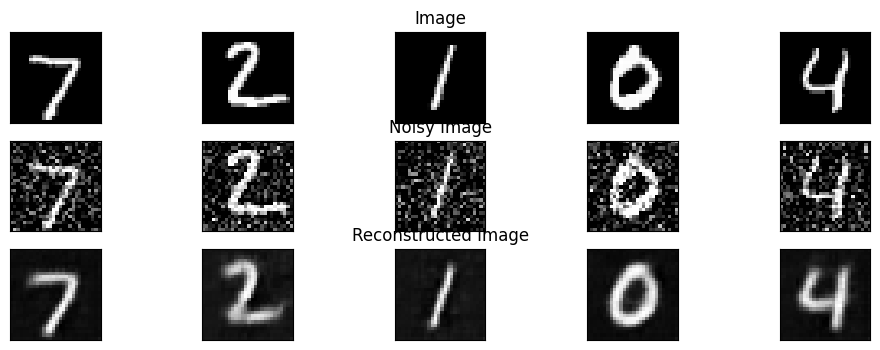

Epoch [11/30], Train Loss: 0.0506, Validation Loss: 0.0396


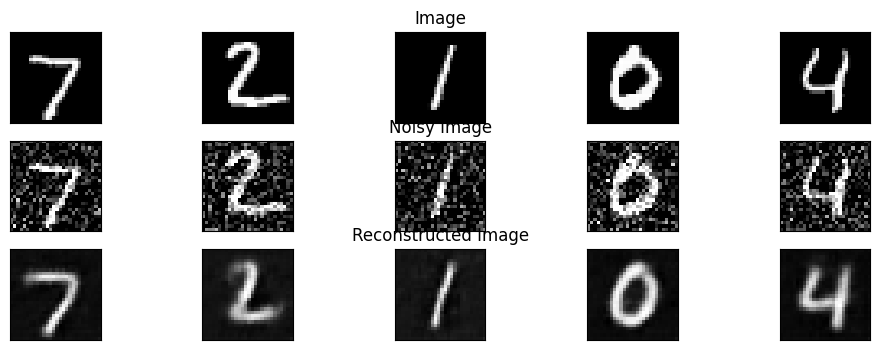

Epoch [12/30], Train Loss: 0.0505, Validation Loss: 0.0393


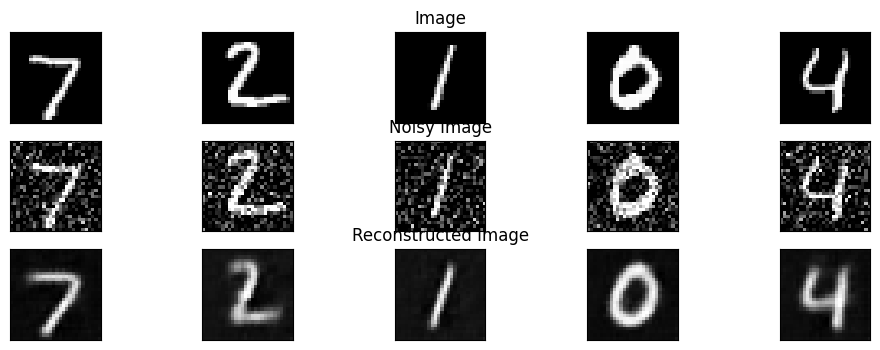

Epoch [13/30], Train Loss: 0.0504, Validation Loss: 0.0391


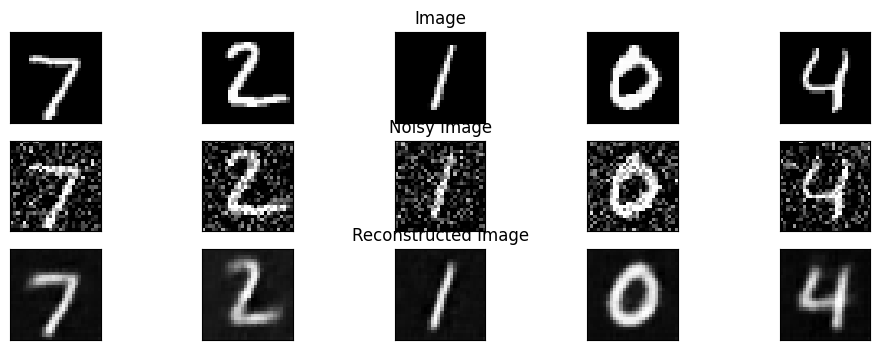

Epoch [14/30], Train Loss: 0.0503, Validation Loss: 0.0390


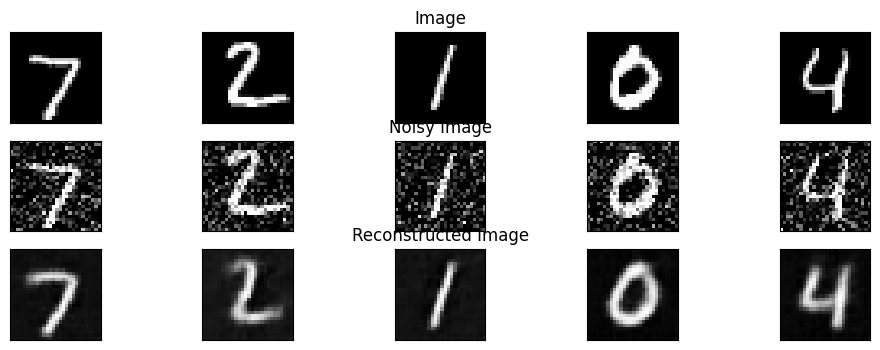

Epoch [15/30], Train Loss: 0.0502, Validation Loss: 0.0390


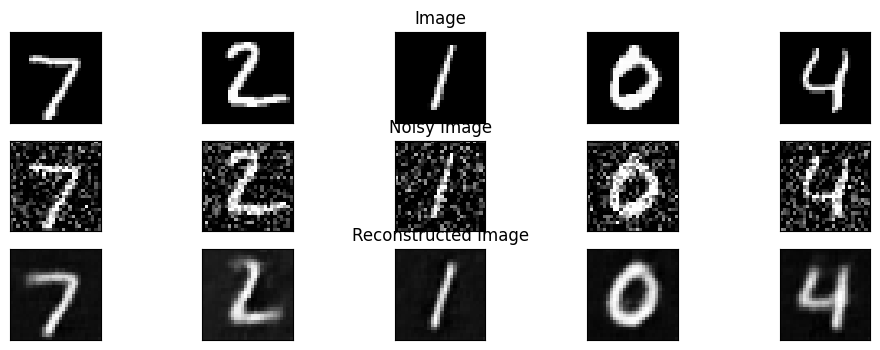

Epoch [16/30], Train Loss: 0.0501, Validation Loss: 0.0391


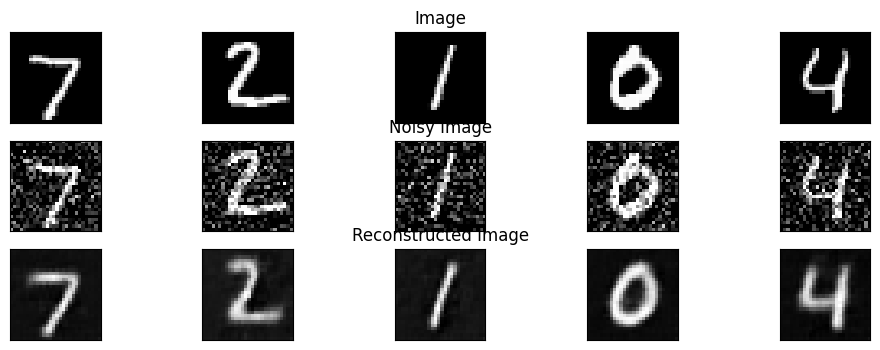

Epoch [17/30], Train Loss: 0.0501, Validation Loss: 0.0386


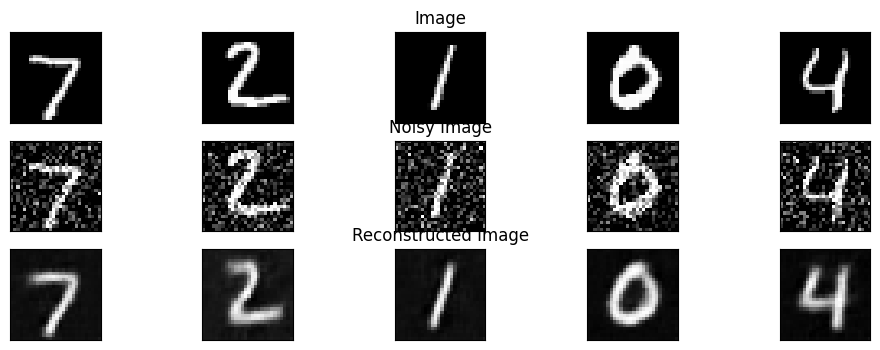

Epoch [18/30], Train Loss: 0.0500, Validation Loss: 0.0390


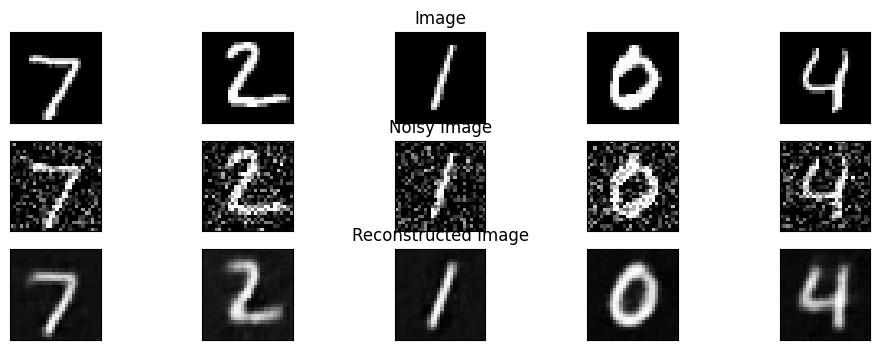

Epoch [19/30], Train Loss: 0.0499, Validation Loss: 0.0387


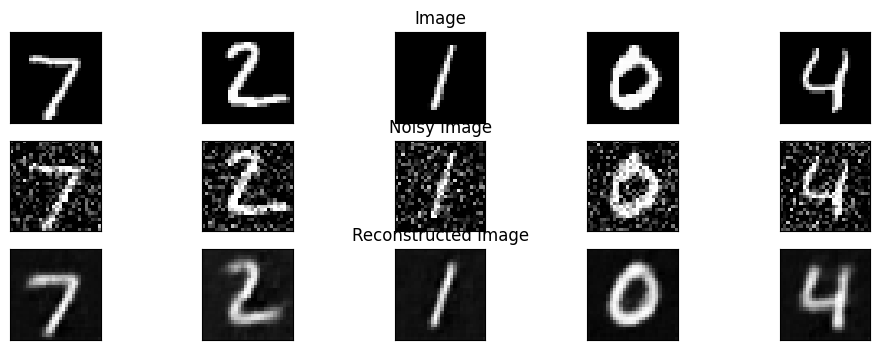

Epoch [20/30], Train Loss: 0.0498, Validation Loss: 0.0384


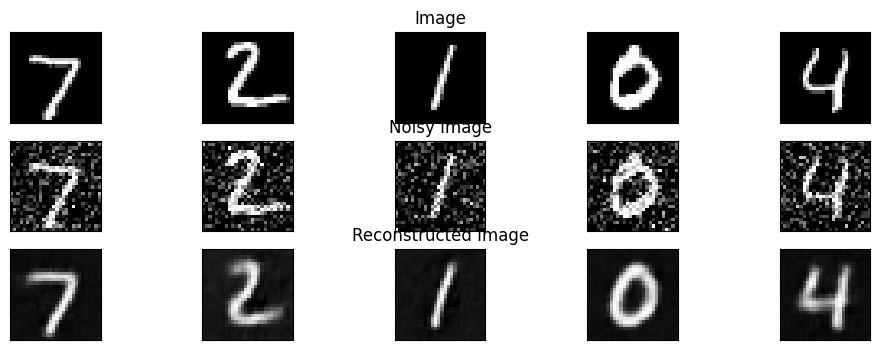

Epoch [21/30], Train Loss: 0.0498, Validation Loss: 0.0382


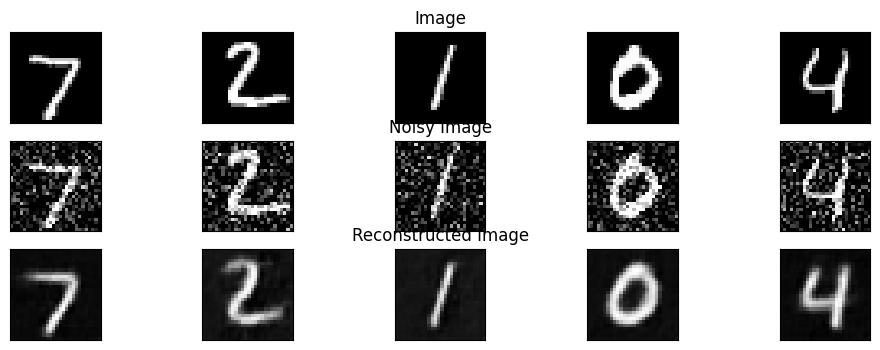

Epoch [22/30], Train Loss: 0.0497, Validation Loss: 0.0381


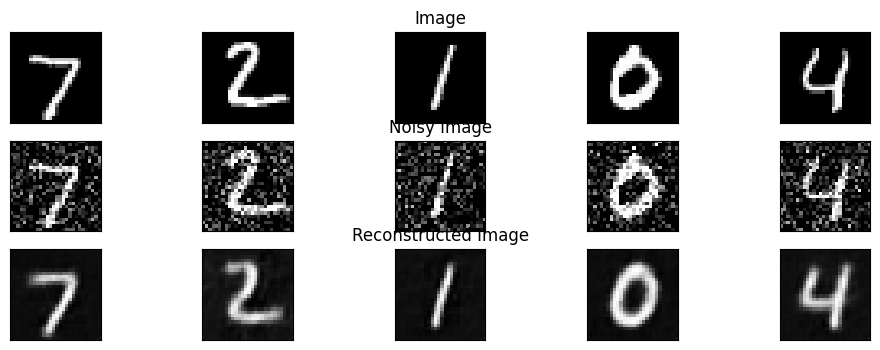

Epoch [23/30], Train Loss: 0.0497, Validation Loss: 0.0382


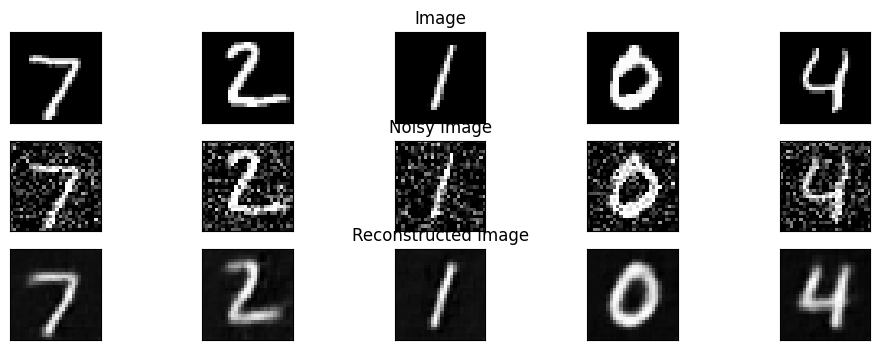

Epoch [24/30], Train Loss: 0.0497, Validation Loss: 0.0384


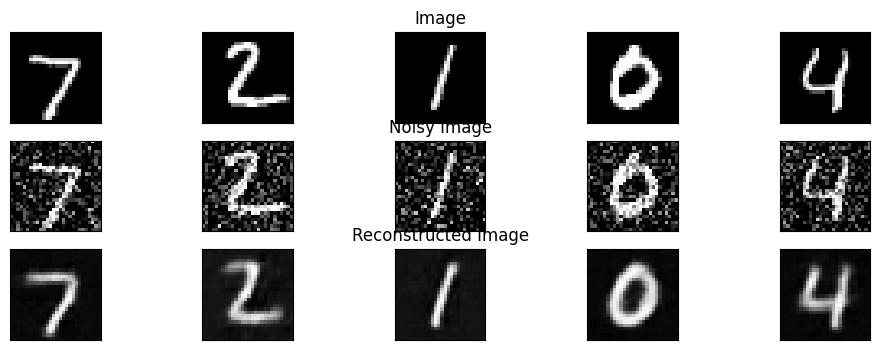

Epoch [25/30], Train Loss: 0.0496, Validation Loss: 0.0379


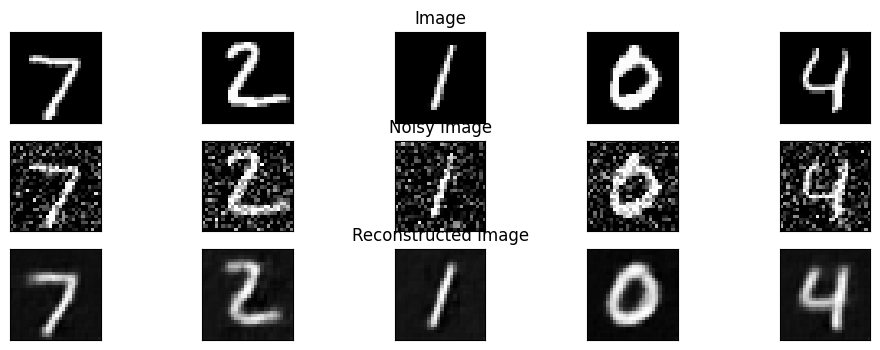

Epoch [26/30], Train Loss: 0.0496, Validation Loss: 0.0382


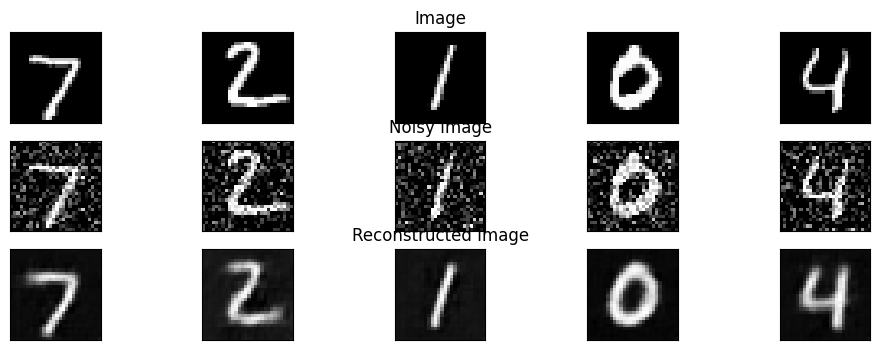

Epoch [27/30], Train Loss: 0.0496, Validation Loss: 0.0383


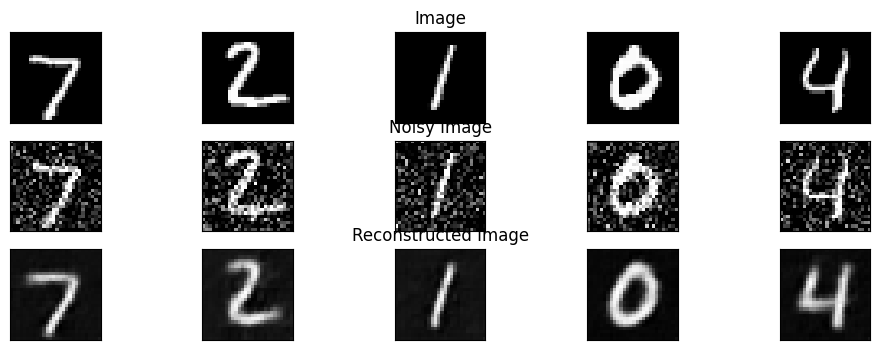

Epoch [28/30], Train Loss: 0.0495, Validation Loss: 0.0383


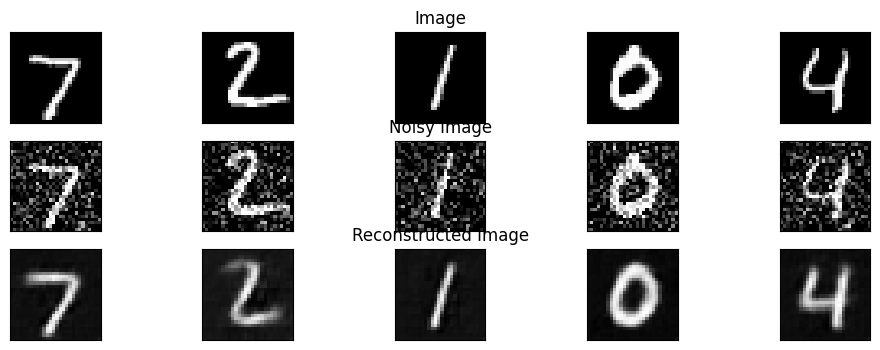

Epoch [29/30], Train Loss: 0.0495, Validation Loss: 0.0380


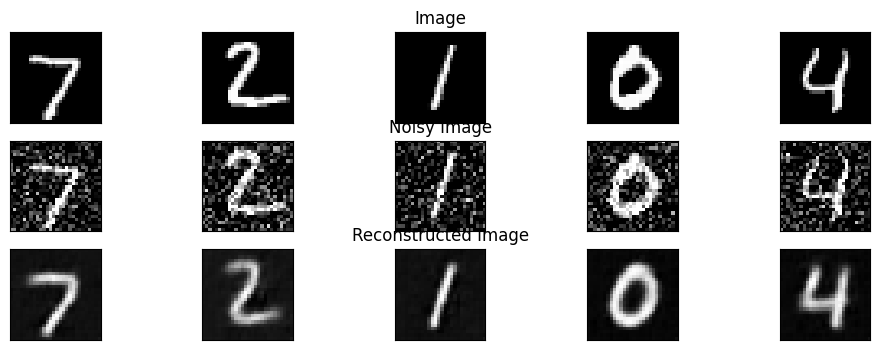

Epoch [30/30], Train Loss: 0.0494, Validation Loss: 0.0379


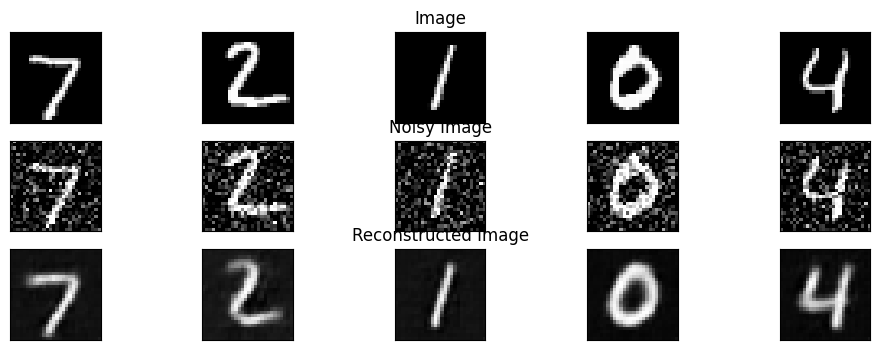

In [16]:
import numpy as np

num_epochs = 30
history_da = {'train_loss': [], 'val_loss': []}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    train_loss = train(encoder, decoder, train_loader, optimizer, loss_fn, device)
    val_loss = test(encoder, decoder, test_loader, device)

    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3)